Installing necessary Libraries


In [33]:
!pip install pytube -q  # pytube: A Python library for downloading YouTube videos (audio or video content)
!pip install yt-dlp  # yt-dlp: A command-line program to download videos from YouTube and other sites, an improved fork of youtube-dl
!pip install pydub  # pydub: A Python library for audio processing (e.g., audio conversion, trimming, and export)
!apt install ffmpeg  # ffmpeg: A tool to handle video, audio, and other multimedia files (used for audio extraction and conversion)
!pip install torch  # torch: PyTorch, a deep learning framework for building and training machine learning models
!pip install torchaudio  # torchaudio: A PyTorch extension for audio processing, works well with PyTorch models for audio tasks


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [34]:
from pytube import YouTube

VIDEO LOADING

In [35]:
VIDEO_URL = 'https://www.youtube.com/watch?v=X3paOmcrTjQ'
yt = YouTube(VIDEO_URL)

In [36]:
import yt_dlp

AUDIO EXTRACTION

In [37]:
def download_audio(video_url, output_path="short_video"):
    try:
        ydl_opts = {
            'format': 'bestaudio/best',
            'outtmpl': output_path,
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'mp3',
                'preferredquality': '192',
            }],
            'nocheckcertificate': True,
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([video_url])
        print("Audio downloaded successfully!")
    except Exception as e:
        print("Error during video download:", e)

download_audio("https://www.youtube.com/watch?v=X3paOmcrTjQ")


[youtube] Extracting URL: https://www.youtube.com/watch?v=X3paOmcrTjQ
[youtube] X3paOmcrTjQ: Downloading webpage
[youtube] X3paOmcrTjQ: Downloading ios player API JSON
[youtube] X3paOmcrTjQ: Downloading mweb player API JSON
[youtube] X3paOmcrTjQ: Downloading m3u8 information
[info] X3paOmcrTjQ: Downloading 1 format(s): 251
[download] Destination: short_video
[download] 100% of    4.68MiB in 00:00:00 at 14.02MiB/s  
[ExtractAudio] Destination: short_video.mp3
Deleting original file short_video (pass -k to keep)
Audio downloaded successfully!


Audio Cleaning


In [39]:
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

# Load audio file
audio = AudioSegment.from_file("short_video.mp3")


nonsilent_intervals = detect_nonsilent(audio, min_silence_len=1000, silence_thresh=-40)
clean_audio = sum([audio[start:end] for start, end in nonsilent_intervals])


clean_audio.export("cleaned_audio.mp3", format="mp3")


<_io.BufferedRandom name='cleaned_audio.mp3'>

In [40]:
! ffmpeg -i cleaned_audio.mp3 -acodec pcm_s16le -ar 16000 ytaudio1.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

AUDIO TRANSCRIPTTION USING TRANSFORMERS

In [41]:
from transformers import pipeline

# Make sure to specify the device as 0 to use the GPU
whisper_model = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    device=0  # Set this to 0 to use the first available GPU
)

result = whisper_model("ytaudio1.wav",return_timestamps=True)
transcript = result['text']
print(transcript)

with open('transcript1.txt', 'w') as f:
    f.write(transcript)

print("Transcript saved to transcript1.txt")


/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:509: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


 Are you one of the many who dreams of becoming a data scientist? Keep watching this video if you're passionate about data science because we will tell you how does it really work under the hood. Emma is a data scientist. Let's see how a day in her life goes while she's working on a data science project. Well, it is very important to understand the business problem first. In our meeting with the clients, Emma asks relevant questions, understands and defines objectives for the problem that needs to be tackled. She is a curious soul who asks a lot of eyes, one of the many traits of a good data scientist. Now she cares up for data acquisition. To gather and scrape data from multiple sources like web servers, logs, databases, APIs and online repositories. Oh, it seems like finding the right data takes both time and effort. After the data is gathered comes data preparation. This step involves data cleaning and data transformation. The cleaning is the most time consuming process as it involv

TRANSCRIPT CLEANING

In [53]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
import re
from nltk.corpus import stopwords

# Define file paths
input_file = "transcript1.txt"
output_file = "cleaned_transcript.txt"

# Load transcript from the input file
with open(input_file, "r") as file:
    transcript = file.read()

# Remove filler words, special characters, and stopwords
stop_words = set(stopwords.words('english'))
cleaned_transcript = " ".join(
    word for word in re.sub(r'[^\w\s]', '', transcript).split()
    if word.lower() not in stop_words
)

# Save the cleaned transcript to the output file
with open(output_file, "w") as file:
    file.write(cleaned_transcript)

print(f"Cleaned transcript has been saved to {output_file}")

Cleaned transcript has been saved to cleaned_transcript.txt


EXPLORATORY DATA ANALYSIS


WORD CLOUD GENERATION


[('data', 36), ('scientist', 8), ('science', 8), ('Emma', 8), ('like', 7), ('model', 6), ('best', 6), ('project', 4), ('Well', 4), ('learning', 4)]


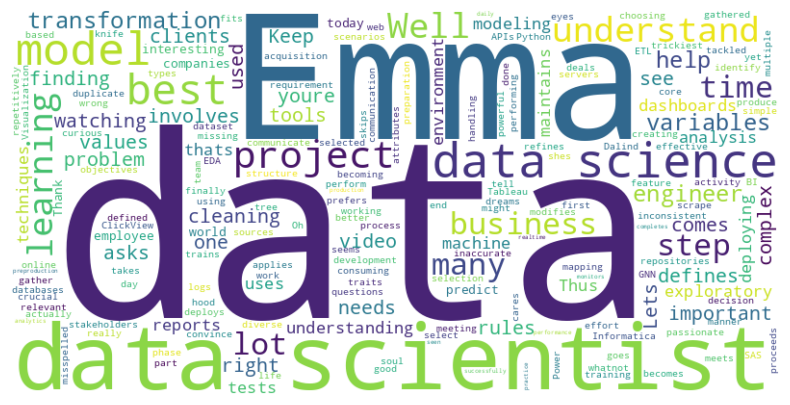

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Example: Word frequency analysis
word_list = cleaned_transcript.split()
word_freq = Counter(word_list)
print(word_freq.most_common(10))

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_transcript)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


WORD LENGTH DISTRIBUTION

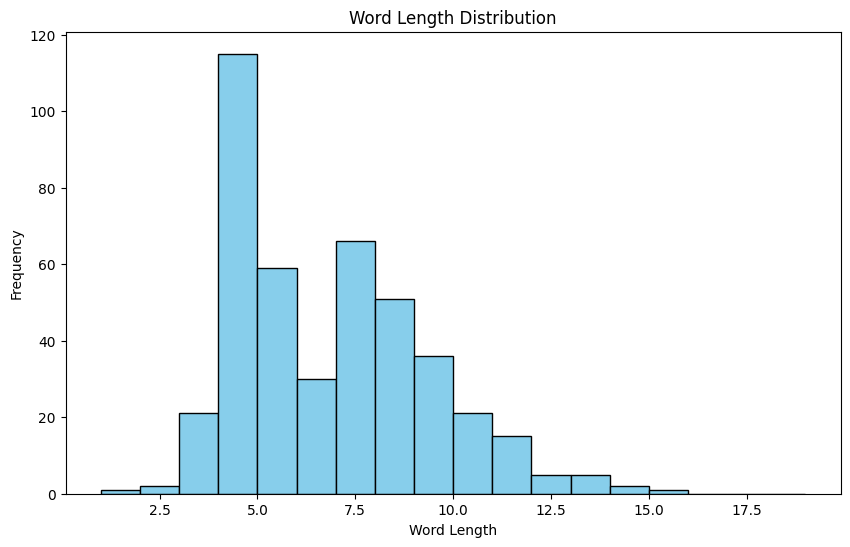

In [45]:
import matplotlib.pyplot as plt

# Word length analysis
word_lengths = [len(word) for word in cleaned_transcript.split()]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=range(1, 20), edgecolor='black', color='skyblue')
plt.title('Word Length Distribution')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()


PARTS OF SPEECH TAGGING

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Part-of-Speech Analysis:
CD: 4
JJ: 42
NNS: 97
VBG: 25
NN: 128
NNP: 37
VBP: 20
RB: 15
VB: 8
VBZ: 22
VBN: 7
IN: 10
VBD: 5
RBR: 1
MD: 1
JJS: 7
CC: 1


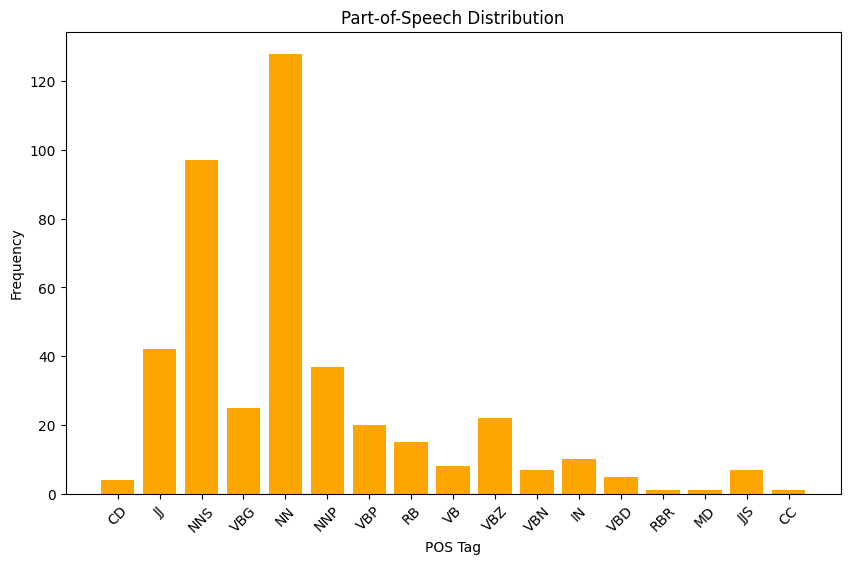

In [46]:
import nltk
from collections import Counter
import matplotlib.pyplot as plt

# Download required NLTK data
nltk.download('averaged_perceptron_tagger_eng')

# Perform POS tagging
words = cleaned_transcript.split()
pos_tags = nltk.pos_tag(words)

# Count POS occurrences
pos_counts = Counter(tag for _, tag in pos_tags)

# Display POS counts
print("Part-of-Speech Analysis:")
for tag, count in pos_counts.items():
    print(f"{tag}: {count}")

# Plot POS counts
plt.figure(figsize=(10, 6))
plt.bar(pos_counts.keys(), pos_counts.values(), color='orange')
plt.title('Part-of-Speech Distribution')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


BIGRAM VISUALIZATION

In [47]:
from nltk.util import ngrams
from collections import Counter

# Generate bigrams
bigrams = list(ngrams(cleaned_transcript.split(), 2))
bigram_counts = Counter(bigrams)

# Display top 10 bigrams
print("Top 10 Bigrams:")
for bigram, count in bigram_counts.most_common(10):
    print(f"{bigram}: {count}")


Top 10 Bigrams:
('data', 'scientist'): 8
('data', 'science'): 7
('science', 'project'): 3
('one', 'many'): 2
('data', 'transformation'): 2
('tools', 'like'): 2
('exploratory', 'data'): 2
('data', 'analysis'): 2
('machine', 'learning'): 2
('reports', 'dashboards'): 2


SUMMARIZING TRANSCRIPT USING MULTIPLE MODELS


SUMMARIZING USING BART MODEL

In [48]:
from transformers import pipeline

# Initialize the summarizer pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Read the original summary from the file
with open("transcript1.txt", "r") as file:
    original_summary = file.read()

# Generate the summarized text
short_summary = summarizer(original_summary, max_length=250, min_length=100, do_sample=False)

# Extract the summary text
summary_text = short_summary[0]['summary_text']

# Write the summary text to a new file
with open("bart_summary.txt", "w") as output_file:
    output_file.write(summary_text)

print(short_summary[0]['summary_text'])
print("Summary saved to 'short_summary_using_bart.txt'.")



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


The median base salaries of a data scientist can range from $95,000 to $165,000. With data science, it is possible to not only predict employee attrition but to also understand the key variables that influence employee turnover. Data science techniques along with genomic data provide a deeper understanding of genetic issues in reaction to particular drugs and diseases. Are you ready to be adata scientist? If yes, then start today. The world of data needs you. That's all from my side today.
Summary saved to 'short_summary_using_bart.txt'.


SUMMARIZING USING PEGASUS MODEL

In [49]:

from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# Load the PEGASUS tokenizer and model
model_name = "google/pegasus-cnn_dailymail"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Read input text from a .txt file
with open("transcript1.txt", "r") as file:
    original_text = file.read()

# Tokenize the input text
inputs = tokenizer(original_text, max_length=150, truncation=True, return_tensors="pt")

# Generate summary
summary_ids = model.generate(inputs["input_ids"], max_length=250, min_length=100, length_penalty=2.0, num_beams=4, early_stopping=True)

# Decode the summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Write the summary to a .txt file
with open("pegasus_summary.txt", "w") as output_file:
    output_file.write(summary)

print("PEGASUS Summary:", summary)
print("Summary saved to 'pegasus_summary.txt'.")



Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEGASUS Summary: Emma is a data scientist working on a data science project .<n>Let's see how a day in her life goes while she's working on a data science project .<n>Emma asks relevant questions, understands and defines objectives for the problem that needs to be tackled .<n>She is a curious soul who asks a lot of eyes, one of the many traits of a good data scientist .<n>Now she cares up for data acquisition .<n>To gather and scrape data from multiple sources like web servers .
Summary saved to 'pegasus_summary.txt'.


SUMMARIZING USING T5 MODEL

In [50]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the T5 tokenizer and model
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Read input text from a .txt file
with open("transcript1.txt", "r") as file:
    original_text = file.read()

# Prepare the input text (T5 uses a prefix "summarize:")
input_text = "summarize: " + original_text

# Tokenize the input text
inputs = tokenizer(input_text, max_length=150, truncation=True, return_tensors="pt")

# Generate summary
summary_ids = model.generate(inputs["input_ids"], max_length=250, min_length=100, length_penalty=2.0, num_beams=6, early_stopping=False)



# Decode the summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Write the summary to a .txt file
with open("t5_summary.txt", "w") as output_file:
    output_file.write(summary)

print("T5 Summary:", summary)

print("Summary saved to 't5_summary.txt'.")



T5 Summary: cnn's ireport boot camp challenges you to become a data scientist . cnn's ireport boot camp challenges you to become a data scientist . cnn's ireport boot camp challenges you to become a data scientist . do you have a dream of becoming a data scientist? share it with cnn ireport and cnn ireport . ireport.com: do you have a dream of becoming a data
Summary saved to 't5_summary.txt'.


In [51]:
pip install openai==0.28

SUMMARIZING USING GPT MODEL


In [57]:
import openai

# Load your OpenAI API key
openai.api_key = " enter ur api key "

# Read input text from a .txt file
with open("transcript1.txt", "r") as file:
    original_text = file.read()

# Define the system and user messages
messages = [
    {"role": "system", "content": "You are a creative assistant specializing in designing AI prompts for image generation."},
    {"role": "user", "content": f"Refine the following text into a more detailed and descriptive form:\n\n{original_text}"}
]


# Call the OpenAI ChatCompletion API
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",  # Replace with "gpt-4" if accessible
    messages=messages,
    max_tokens=150,
    temperature=0.7
)

# Extract the summary
summary = response['choices'][0]['message']['content'].strip()
print("GPT Summary:", summary)

# Write the summary to a .txt file
with open("gpt_summary.txt", "w") as output_file:
    output_file.write(summary)

print("Summary saved to 'gpt_summary.txt'.")

GPT Summary: Are you among the countless individuals who harbor aspirations of delving into the realm of data science? If the world of data science ignites a spark within you, continue watching this video as we unveil the intricate workings beneath the surface. Meet Emma, a dedicated data scientist whose daily routine offers a glimpse into the captivating world of data science projects. The journey kicks off with a meticulous analysis of the business problem at hand. During client meetings, Emma's inquisitive nature shines as she poses pertinent questions, grasps the objectives, and defines strategies to tackle the challenges ahead. 

Next, Emma embarks on the crucial phase of data acquisition, scouring various sources such as web servers, logs, databases, APIs, and online repositories to gather and scrape
Summary saved to 'gpt_summary.txt'.


In [56]:
import openai

# Load your OpenAI API key
openai.api_key = "please enter ur api key "

# Read input text from a .txt file
with open("transcript1.txt", "r") as file:
    original_text = file.read()

# Define the system and user messages
messages = [
    {"role": "system", "content": "You are a creative assistant specializing in refining text into a more detailed and descriptive form."},
    {"role": "user", "content": f"Refine the following text into a more detailed and descriptive form:\n\n{original_text}"}
]


# Call the OpenAI ChatCompletion API
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",  # Replace with "gpt-4" if accessible
    messages=messages,
    max_tokens=150,
    temperature=0.7
)

# Extract the summary
summary = response['choices'][0]['message']['content'].strip()
print("GPT Summary:", summary)

# Write the summary to a .txt file
with open("gpt2_summary.txt", "w") as output_file:
    output_file.write(summary)

print("Summary saved to 'gpt2_summary.txt'.")

GPT Summary: Are you among the multitude who harbors the ambitious dream of becoming a proficient data scientist, delving into the intricate world of data science? If so, stay tuned to this enlightening video, especially crafted for those with a deep-rooted passion for the realm of data science, as we unravel the inner workings of this captivating field. Meet Emma, a dedicated data scientist, whose daily endeavors offer a glimpse into the captivating journey of working on a data science project.

Embarking on her quest, Emma places paramount importance on comprehending the underlying business problem. Engaging in insightful dialogues with clients, she meticulously poses pertinent questions, adept at deciphering and outlining clear objectives essential for addressing the challenges at hand. With an insatiable curiosity that drives
Summary saved to 'gpt2_summary.txt'.


GENERATING IMAGES USING ABOVE GENERATED SUMMARIES

IMAGE GENERATION BY USING BART SUMMARY








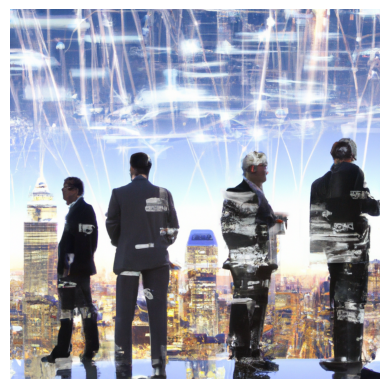

In [62]:


import openai
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Set up your OpenAI API key
openai.api_key = 'please enter ur api key '  # Replace with your actual OpenAI API key

# Read the text prompt from bart_summary.txt
with open("bart_summary.txt", "r") as file:
    prompt = file.read().strip()

# Generate an image using the DALL-E model
def generate_image_from_text(prompt):
    # Use openai.Image.create() to generate an image
    response = openai.Image.create(
        prompt=prompt,  # The text prompt for the image
        n=1,            # Number of images to generate
        size="1024x1024" # Image size
    )

    # Get the URL of the generated image
    image_url = response['data'][0]['url']  # Access the 'url' from the 'data' list

    # Download and display the image
    image_response = requests.get(image_url)
    img = Image.open(BytesIO(image_response.content))

    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

# Call the function to generate and display the image
generate_image_from_text(prompt)





IMAGE GENERATION BY USING PEGASUS SUMMARY

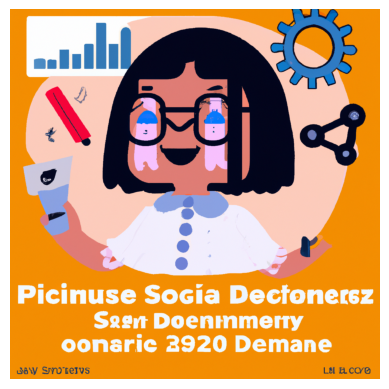

In [61]:
import openai
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Set up your OpenAI API key
openai.api_key = 'enter ur api key  ' # Replace with your actual OpenAI API key

# Define the text prompt
with open("pegasus_summary.txt", "r") as file:
    prompt = file.read().strip()

# Generate an image using the DALL-E model
def generate_image_from_text(prompt):
    # Use openai.Image.create() to generate an image
    response = openai.Image.create(
        prompt=prompt,  # The text prompt for the image
        n=2,            # Number of images to generate
        size="1024x1024" # Image size
    )

    # Get the URL of the generated image
    image_url = response['data'][0]['url']  # Access the 'url' from the 'data' list

    # Download and display the image
    image_response = requests.get(image_url)
    img = Image.open(BytesIO(image_response.content))

    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

# Call the function to generate and display the image
generate_image_from_text(prompt)


IMAGE GENERATION BY USING T5 SUMMARY

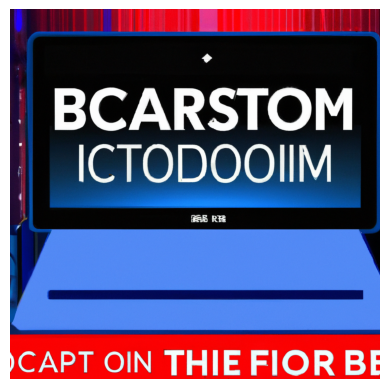

In [60]:
import openai
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Set up your OpenAI API key
openai.api_key = ' enter ur api key  '

with open("t5_summary.txt", "r") as file:
    prompt = file.read().strip()


# Generate an image using the DALL-E model
def generate_image_from_text(prompt):
    # Use openai.Image.create() to generate an image
    response = openai.Image.create(
        prompt=prompt,  # The text prompt for the image
        n=1,            # Number of images to generate
        size="1024x1024" # Image size
    )

    # Get the URL of the generated image
    image_url = response['data'][0]['url']  # Access the 'url' from the 'data' list

    # Download and display the image
    image_response = requests.get(image_url)
    img = Image.open(BytesIO(image_response.content))

    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

# Call the function to generate and display the image
generate_image_from_text(prompt)


IMAGE GENERATION BY USING GPT SUMMARY


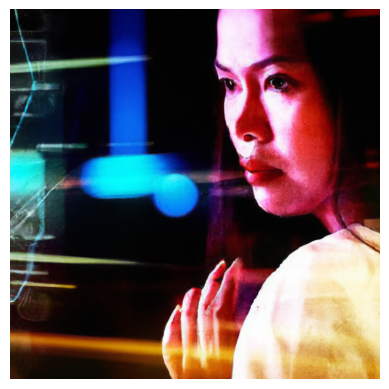

In [58]:
import openai
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

openai.api_key = ' enter ur api key  '

# Read the prompt from the file
with open("gpt_summary.txt", "r") as file:
    prompt = file.read().strip()

def generate_images_from_text(prompt):
    # Generate images using the DALL-E model
    response = openai.Image.create(
        prompt=prompt,
        n=1,
        size="1024x1024"
    )

     # Get the URL of the generated image
    image_url = response['data'][0]['url']  # Access the 'url' from the 'data' list

    # Download and display the image
    image_response = requests.get(image_url)
    img = Image.open(BytesIO(image_response.content))

    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

# Call the function to generate and display the image
generate_image_from_text(prompt)
